In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from IPython import display
import random

# mastering randomness
seed = 12345
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# load data
curves = [
  'ATGPig',
  'ATG5pc',
  'ATG10pc',
  'ATG15pc',
  'ATG20pc',
  'ATG25pc',
  'ATG35pc',
  'ATGcala'
]
columns = [
  'time',
  'temperature',
  'weight',
  'heat flow',
  'temperature difference (°C)',
  'temperature difference (µV)',
  'Sample purge flow',
  'Unknown #!'
]

def load_data():
  data = dict.fromkeys(curves)
  for curve in curves:
    display.clear_output(wait=True)
    print('loading ', curve, '...')
    data[curve] = pd.read_csv('../misc/'+curve+'.csv', delimiter=',', header=0, names=columns)
  return data

dataset = load_data()

loading  ATGcala ...


In [3]:
# normalization
# dataset = tf.keras.utils.normalize(dataset, axis=0)
# target = tf.keras.utils.normalize(target, axis=0)

In [4]:
dataset['ATG35pc'].head()

,time,temperature,weight,heat flow,temperature difference (°C),temperature difference (µV),Sample purge flow,Unknown #!
0,0.002933,50.76896,73.66430,6.321343,0.193805,1.222940,99.90224,#DIV/0!
1,0.004333,50.75010,73.66421,6.339770,0.195705,1.234863,100.00460,#DIV/0!
2,0.012667,50.73641,73.66413,6.358082,0.197594,1.246714,100.14810,#DIV/0!
3,0.021000,50.71924,73.66404,6.376664,0.199510,1.258736,99.87906,#DIV/0!
4,0.029333,50.69856,73.66394,6.395057,0.201408,1.270640,99.92707,#DIV/0!


In [5]:
dataset['ATG25pc'].head()

,time,temperature,weight,heat flow,temperature difference (°C),temperature difference (µV),Sample purge flow,Unknown #!
0,0.000733,50.77950,69.46993,6.398750,0.201700,1.272806,99.84804,0.002983
1,0.004333,50.76366,69.46984,6.414462,0.203323,1.282980,100.08630,0.002984
2,0.012667,50.74692,69.46969,6.429982,0.204927,1.293031,100.00130,0.002985
3,0.021000,50.73253,69.46957,6.445824,0.206564,1.303288,99.93726,0.002985
4,0.029333,50.71080,69.46947,6.461283,0.208162,1.313300,100.10530,0.002986


In [6]:
TRAINING_COLUMNS = [
  'weight',
  'heat flow',
  'temperature difference (°C)',
  'Sample purge flow',
]
LABELLING_COLUMNS = [
  'weight',
  'temperature difference (°C)'
]

# Data Preparation

## Reconstruction of ATG10pc with f(ATGPig, ATGcala)

In [7]:
CURVES_OF_INTEREST = [
  'ATGPig',
  'ATGcala'
]
TARGET_CURVE = 'ATG10pc'

temperature = np.expand_dims(dataset[TARGET_CURVE]['temperature'].to_numpy()[:3000], axis=1)
column_10pc = 10 * np.expand_dims(np.ones(3000, dtype='float'), axis=1)
column_0pc = np.expand_dims(np.zeros(3000, dtype='float'), axis=1)
column_100pc = 100 * np.expand_dims(np.ones(3000, dtype='float'), axis=1)
toto = np.concatenate(
  [
    temperature, column_10pc, column_0pc, column_100pc
  ],
  axis=1
)

data_pig_cala = np.concatenate(
  [
    dataset[curve][TRAINING_COLUMNS].to_numpy()[:3000]
    for curve in CURVES_OF_INTEREST
  ],
  axis=1
)
data_pig_cala = np.concatenate((toto, data_pig_cala), axis=1)
data_pig_cala = np.expand_dims(data_pig_cala, axis=1)

labels_10pc = dataset[TARGET_CURVE][LABELLING_COLUMNS].to_numpy()[:3000]
print(data_pig_cala.shape)
print(data_pig_cala[0])
print(data_pig_cala[1])
print(data_pig_cala[2])

(3000, 1, 12)
[[ 50.71644    10.          0.        100.         30.29117     5.58716
    0.1188674 100.0713     67.69134     7.330881    0.2968466 100.0324   ]]
[[ 50.696      10.          0.        100.         30.29106     5.599843
    0.1201776 100.0023     67.69134     7.341944    0.2980032 100.0404   ]]
[[ 50.68036    10.          0.        100.         30.29101     5.612566
    0.1214928  99.9947     67.69132     7.352965    0.299156   99.84942  ]]


In [8]:
# normalization
# data_pig_cala = tf.keras.utils.normalize(data_pig_cala, axis=0)
# labels_5pc = tf.keras.utils.normalize(labels_5pc, axis=0)
# print(data_pig_cala[0])
# print(data_pig_cala[1])
# print(data_pig_cala[2])

In [9]:
# choose curves and target
data = data_pig_cala
labels = labels_10pc

# split into train and test ---------(1)
#idx = random.sample(range(len(data)), len(data))
#train_idx, test_idx = idx[:2000], idx[2000:]

# ShuffleSplit  ---------(2)
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=seed)
train_idx = []
test_idx = []
for train_idx, test_idx in ss.split(range(len(data))):
    train_idx, test_idx = train_idx, test_idx
# meta-segmented train/test split ---------(3)


# Domain-based train/test split: ---------(4)
#  This technique is based on the available analytical models
#  in order to provide train/test splits from different curves.
#  The goal is obviously to construct models with more powerful
#  generalization capabilities.

# data generation functions
def gen_datum(idx, test=False):
  return data[idx], labels[idx]

def gen_train_data():
  for idx in train_idx:
    yield gen_datum(idx, test=False)

def gen_test_data():
  for idx in test_idx:
    yield gen_datum(idx, test=False)

print(data.shape)
print(labels.shape)

(3000, 1, 12)
(3000, 2)


In [10]:
# model definition
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.inference_net = tf.keras.Sequential(
      [
        tf.keras.layers.Dense(8, input_dim=12, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='linear')
      ]
    )
    
  def call(self, x):
    return self.predict(x)
    
  def predict(self, x):
    return self.inference_net(x)

model = Model()

In [11]:
tf.keras.backend.clear_session()

epochs = 100

mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-4)

def compute_loss(model, x, y):
  y_pred = model.call(x)
  return mse(y_pred, y)

@tf.function
def compute_apply_gradients(model, x, y, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x, y)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

In [12]:
# keep track of losses
train_loss_list=[]
test_loss_list=[]

In [13]:
# training
for epoch in range(1, epochs + 1):
  start_time = time.time()
  train_mean = tf.keras.metrics.Mean()
  for train_x, train_y in gen_train_data():
    train_mean(compute_apply_gradients(model, train_x, train_y, optimizer))
  train_loss_list.append(train_mean.result())
  end_time = time.time()

  if epoch % 1 == 0:
    test_mean = tf.keras.metrics.Mean()
    for test_x, test_y in gen_test_data():
      test_mean(compute_loss(model, test_x, test_y))
    test_loss_list.append(test_mean.result())
    display.clear_output(wait=True)
    print('Epoch: {}, Train loss: {}, Test loss: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    train_mean.result(),
                                                    test_mean.result(),
                                                    end_time - start_time))

Epoch: 100, Train loss: 0.02283422276377678, Test loss: 0.10515864938497543, time elapse for current epoch 2.4134328365325928


In [14]:
print(list(set(train_idx) & set(test_idx)))

[]


# Some plots

## Plot functions

In [19]:
# Plot evolution of the loss
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

def plot_loss(train_loss_list, test_loss_list):
  plt.figure(figsize=(15, 5));
  fig, ax1 = plt.subplots()
  ax1.yaxis.grid(False)
  ax1.set_ylim([-0.2, 1])
  
  train_l = [res.numpy() for res in train_loss_list]
  test_l = [res.numpy() for res in test_loss_list]
  print(len(train_l))
  ax1.plot(train_l, label='train loss', color=plt.cm.YlGnBu(2/4.), linewidth='1')
  ax1.plot(test_l, label='test loss', color=plt.cm.YlGnBu(4/4.), linewidth='1')
  
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Mean squared error')
  ax1.set_xscale('log')
  ax1.legend(loc='best')

  return fig

In [16]:
def plot_reconstruction(original, reconstructed, name='weight (\%)'):
  plt.figure(figsize=(15, 5));
  fig, ax1 = plt.subplots()
  ax1.yaxis.grid(False)

  markers_on = [on for on in range(3000) if on % 80 == 0]
  ax1.plot(original, label='original', color=plt.cm.YlGnBu(2/4.), linestyle='--', marker='o', markevery=markers_on)
  ax1.plot(reconstructed, label='reconstructed', color=plt.cm.YlGnBu(4/4.), linestyle='--', marker='D', markevery=markers_on)

  ax1.set_xlabel('Time')
  ax1.set_ylabel(name)
  ax1.legend(loc='best')

  return fig

## Save and plot results of f<sub>10pc</sub>(ATGpig, ATGcala)

In [39]:
# Save model and losses
train_loss_list_10pc = train_loss_list
test_loss_list_10pc = test_loss_list
model_10pc = model
model._set_inputs(data_pig_cala)
!mkdir -p saved_model_Nov08
model_10pc.save('results/saved_model_Nov08/f_pig_cala_10pc.model')
np.savetxt('saved_model_Nov08/f_pig_cala_10pc.train_losses', train_loss_list_10pc)
np.savetxt('saved_model_Nov08/f_pig_cala_10pc.test_losses', test_loss_list_10pc)

INFO:tensorflow:Assets written to: results/saved_model_Nov08/f_pig_cala_10pc.model/assets


100


<Figure size 1080x360 with 0 Axes>

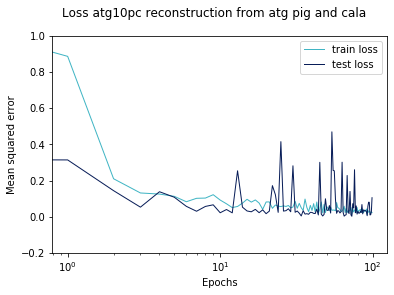

In [20]:
fig = plot_loss(train_loss_list_10pc, test_loss_list_10pc)
fig.suptitle('Loss atg10pc reconstruction from atg pig and cala')
plt.savefig(fname='./results/loss-atg10-from-atgpig-atgcala.svg', format='svg')

# Reconstructions

## TGA<sub>5pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 5pc)

In [23]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 5 * np.ones(3000)
predictions_5pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_5pc.shape)
labels_5pc = dataset['ATG5pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

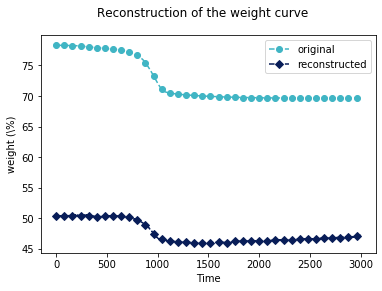

<Figure size 1080x360 with 0 Axes>

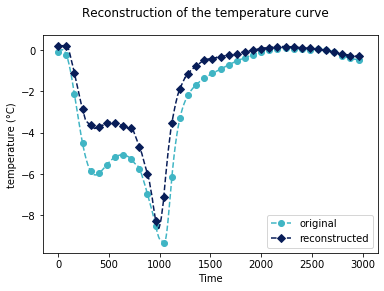

In [24]:
fig = plot_reconstruction(labels_5pc[:, 0], predictions_5pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/5pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_5pc[:, 1], predictions_5pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/5pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

## TGA<sub>10pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 10pc)

In [25]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 10 * np.ones(3000)
predictions_10pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_10pc.shape)
labels_10pc = dataset['ATG10pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

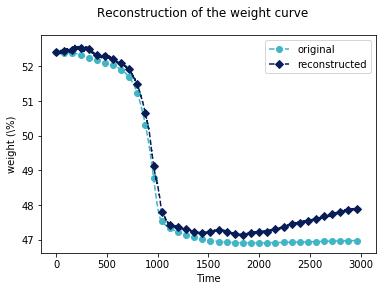

<Figure size 1080x360 with 0 Axes>

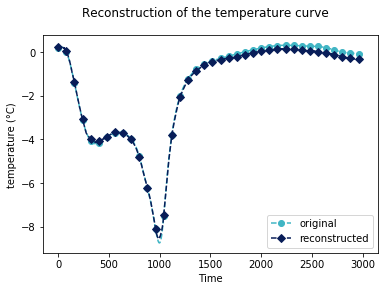

In [26]:
fig = plot_reconstruction(labels_10pc[:, 0], predictions_10pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/10pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_10pc[:, 1], predictions_10pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/10pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

## TGA<sub>15pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 15pc)

In [27]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 15 * np.ones(3000)
predictions_15pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_15pc.shape)
labels_15pc = dataset['ATG15pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

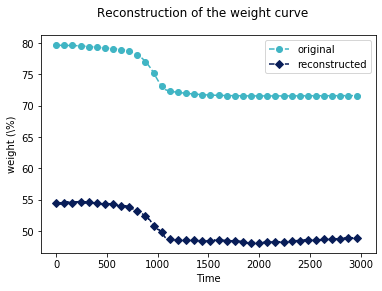

<Figure size 1080x360 with 0 Axes>

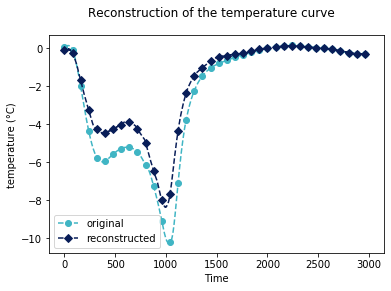

In [28]:
fig = plot_reconstruction(labels_15pc[:, 0], predictions_15pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/15pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_15pc[:, 1], predictions_15pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/15pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

## TGA<sub>20pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 20pc)

In [29]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 20 * np.ones(3000)
predictions_20pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_20pc.shape)
labels_20pc = dataset['ATG20pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

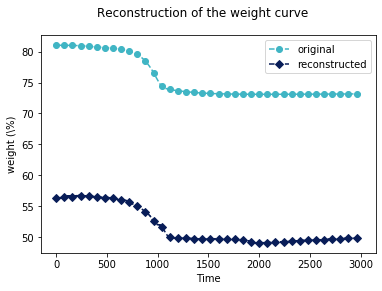

<Figure size 1080x360 with 0 Axes>

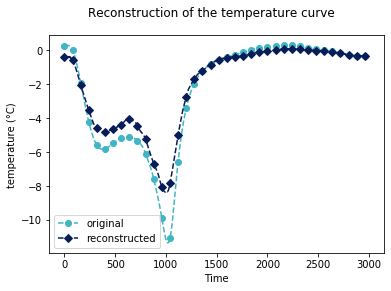

In [30]:
fig = plot_reconstruction(labels_20pc[:, 0], predictions_20pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/20pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_20pc[:, 1], predictions_20pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/20pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

## TGA<sub>25pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 25pc)

In [31]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 25 * np.ones(3000)
predictions_25pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_25pc.shape)
labels_25pc = dataset['ATG25pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

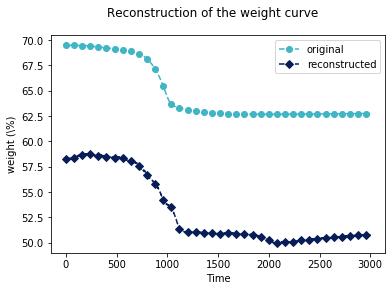

<Figure size 1080x360 with 0 Axes>

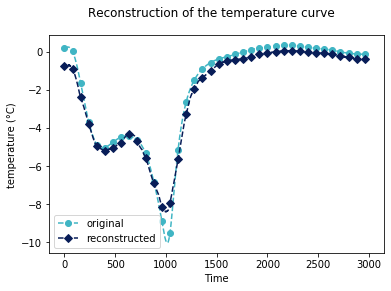

In [32]:
fig = plot_reconstruction(labels_25pc[:, 0], predictions_25pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/25pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_25pc[:, 1], predictions_25pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/25pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

## TGA<sub>35pc</sub>= f<sub>10pc</sub>(TGApig, TGAcala, 35pc)

In [34]:
# Perform reconstuction
test = data_pig_cala
test[:,0, 1] = 35 * np.ones(3000)
predictions_35pc = np.array([model_10pc.call(x) for x in data_pig_cala])
print(predictions_35pc.shape)
labels_35pc = dataset['ATG35pc'][LABELLING_COLUMNS].to_numpy()[:3000]

(3000, 1, 2)


<Figure size 1080x360 with 0 Axes>

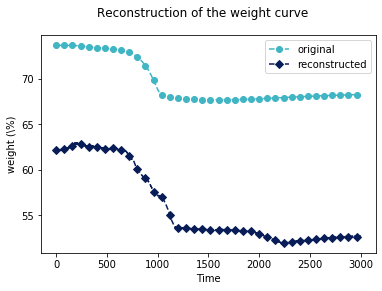

<Figure size 1080x360 with 0 Axes>

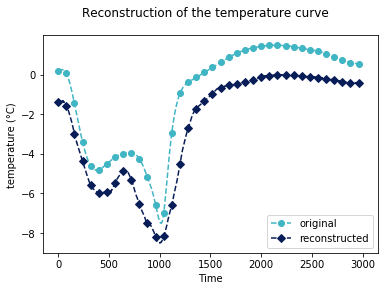

In [35]:
fig = plot_reconstruction(labels_35pc[:, 0], predictions_35pc[:, 0, 0], name='weight (\%)')
fig.suptitle('Reconstruction of the weight curve')
fig.savefig(fname='./results/35pc-weight-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

fig = plot_reconstruction(labels_35pc[:, 1], predictions_35pc[:, 0, 1], name='temperature (°C)')
fig.suptitle('Reconstruction of the temperature curve')
fig.savefig(fname='./results/35pc-temperature-reconstuction-from-atg10=f(atgpig-atgcala).svg', format='svg')

# Error rate as a function of the granularity of real experiments

<Figure size 1080x360 with 0 Axes>

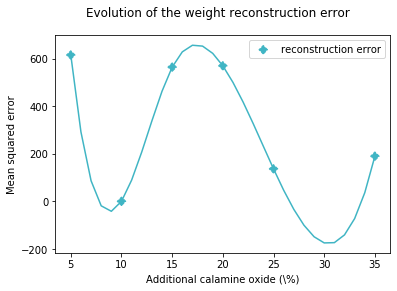

<Figure size 1080x360 with 0 Axes>

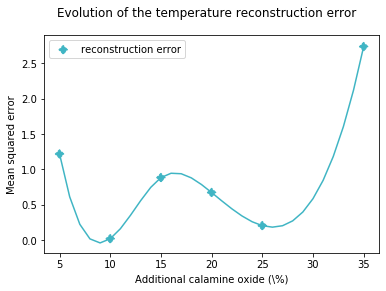

In [37]:
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import interp1d


def aggr_reconstruction_errors(originals, reconstructions, wgt_or_temp=0):
  errs = []
  for orig, recons in zip(originals, reconstructions):
    errs.append(mse(orig[:,wgt_or_temp], recons[:, 0, wgt_or_temp]))
  return errs

def plot_recons_error_evolution(pcxs, recons_errs):
  plt.figure(figsize=(15, 5));
  fig, ax1 = plt.subplots()
  ax1.yaxis.grid(False)

  markers_on = [on for on in range(6) if on % 80 == 0]
  ax1.scatter(pcxs, recons_errs, label='reconstruction error',
              color=plt.cm.YlGnBu(2/4.), linestyle='--', marker='D') #, markevery=markers_on)
  interp = interp1d(pcxs, recons_errs, kind='cubic')
  ax1.plot(range(5, 36), interp(range(5, 36)), color=plt.cm.YlGnBu(2/4.))

  ax1.set_xlabel('Additional calamine oxide (\%)')
  ax1.set_ylabel('Mean squared error')
  ax1.legend(loc='best')

  return fig

pcxs = [
  5,
  10,
  15,
  20,
  25,
  35
]
originals = [
  labels_5pc,
  labels_10pc,
  labels_15pc,
  labels_20pc,
  labels_25pc,
  labels_35pc
]
reconstructions = [
  predictions_5pc,
  predictions_10pc,
  predictions_15pc,
  predictions_20pc,
  predictions_25pc,
  predictions_35pc,
]

recons_errs = aggr_reconstruction_errors(originals, reconstructions, wgt_or_temp=0)
fig = plot_recons_error_evolution(pcxs, recons_errs)
fig.suptitle('Evolution of the weight reconstruction error')
fig.savefig(fname='./results/evolution-of-weight-reconstuction-error-from-atg10=f(atgpig-atgcala).svg', format='svg')

recons_errs = aggr_reconstruction_errors(originals, reconstructions, wgt_or_temp=1)
fig = plot_recons_error_evolution(pcxs, recons_errs)
fig.suptitle('Evolution of the temperature reconstruction error')
fig.savefig(fname='./results/evolution-of-temperature-reconstuction-error-from-atg10=f(atgpig-atgcala).svg', format='svg')

# Quantifying the tradeoff